Submission with stacking with logistic regression, knn, xgboost and random forest

In [1]:
import json
import pandas as pd
import os
import numpy as np

# --- Define the path to our data ---
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
DATA_PATH = os.path.join('../input', COMPETITION_NAME)

train_file_path = os.path.join(DATA_PATH, 'train.jsonl')
test_file_path = os.path.join(DATA_PATH, 'test.jsonl')

In [2]:
train_data = []

print(f"Loading data from '{train_file_path}'...")
try:
    with open(train_file_path, 'r') as f:
        for line in f:
            train_data.append(json.loads(line))
        print(f"Successfully loaded {len(train_data)} battles.")
        
    # Let's inspect the first battle to see its structure
    print("\n--- Structure of the first train battle: ---")
    if train_data:
        first_battle = train_data[0]
        
        battle_for_display = first_battle.copy()
        battle_for_display['battle_timeline'] = battle_for_display.get('battle_timeline', []) [:2] # Show first 2 turns
        
        print(json.dumps(battle_for_display, indent=4))
        if len(first_battle.get('battle_timeline', [])) > 2:
            print("    ...")
            print("    (battle_timeline has been truncated for display)")


except FileNotFoundError:
    print(f"ERROR: Could not find the training file at '{train_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")

Loading data from '../input/fds-pokemon-battles-prediction-2025/train.jsonl'...
Successfully loaded 10000 battles.

--- Structure of the first train battle: ---
{
    "player_won": true,
    "p1_team_details": [
        {
            "name": "starmie",
            "level": 100,
            "types": [
                "psychic",
                "water"
            ],
            "base_hp": 60,
            "base_atk": 75,
            "base_def": 85,
            "base_spa": 100,
            "base_spd": 100,
            "base_spe": 115
        },
        {
            "name": "exeggutor",
            "level": 100,
            "types": [
                "grass",
                "psychic"
            ],
            "base_hp": 95,
            "base_atk": 95,
            "base_def": 85,
            "base_spa": 125,
            "base_spd": 125,
            "base_spe": 55
        },
        {
            "name": "chansey",
            "level": 100,
            "types": [
                "normal",

In [3]:
test_data = []

print(f"Loading data from '{test_file_path}'...")
try:
    with open(test_file_path, 'r') as f:
        for line in f:
            test_data.append(json.loads(line))
    
    print("\n--- Structure of the first test battle: ---")
    if test_data:
            first_test_battle = test_data[0]
            
            test_battle_for_display = first_test_battle.copy()
            test_battle_for_display['battle_timeline'] = test_battle_for_display.get('battle_timeline', [])[:2] # Show first 2 turns
            
            print(json.dumps(test_battle_for_display, indent=4))
            if len(first_test_battle.get('battle_timeline', [])) > 3:
                print("    ...")
                print("    (battle_timeline has been truncated for display)")


except FileNotFoundError:
    print(f"ERROR: Could not find the training file at '{test_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")

Loading data from '../input/fds-pokemon-battles-prediction-2025/test.jsonl'...

--- Structure of the first test battle: ---
{
    "p1_team_details": [
        {
            "name": "gengar",
            "level": 100,
            "types": [
                "ghost",
                "poison"
            ],
            "base_hp": 60,
            "base_atk": 65,
            "base_def": 60,
            "base_spa": 130,
            "base_spd": 130,
            "base_spe": 110
        },
        {
            "name": "chansey",
            "level": 100,
            "types": [
                "normal",
                "notype"
            ],
            "base_hp": 250,
            "base_atk": 5,
            "base_def": 5,
            "base_spa": 105,
            "base_spd": 105,
            "base_spe": 50
        },
        {
            "name": "exeggutor",
            "level": 100,
            "types": [
                "grass",
                "psychic"
            ],
            "base_hp": 

In [4]:
types = [
    "bug", "dark", "dragon", "electric", "fairy", "fighting", "fire", "flying",
    "ghost", "grass", "ground", "ice", "normal", "poison", "psychic", "rock",
    "steel", "stellar", "water"
]

# Matrix of effectivnesses
# x2 = 2.0, x½ = 0.5, x0 = 0.0, x1 = 1.0
# Each row refers to the type of the attack, Each row refers to the type of the defender
type_chart = np.array([
#  Bu  Da  Dr  El  Fa  Fi  Fi  Fl  Gh  Gr  Gr  Ic  No  Po  Ps  Ro  St  St  Wa
  [1,  2,  1,  1,  1,  0.5,0.5,0.5,1,  2,  1,  1,  1,  0.5,2,  1,  0.5,1,  1],  # Bug
  [1,  0.5,1,  1,  2,  1,  1,  1,  2,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1],  # Dark
  [1,  1,  2,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0.5,1,  1],  # Dragon
  [1,  1,  0.5,0.5,1,  1,  1,  2,  1,  0.5,0,  1,  1,  1,  1,  1,  1,  1,  2],  # Electric
  [1,  2,  2,  1,  1,  0.5,0.5,1,  1,  1,  1,  1,  1,  0.5,1,  1,  0.5,1,  1],  # Fairy
  [0.5,2,  1,  1,  0.5,1,  1,  0,  1,  1,  1,  2,  1,  0.5,2,  2,  1,  1,  1],  # Fighting
  [0.5,1,  0.5,1,  1,  1,  0.5,1,  1,  2,  1,  2,  1,  1,  1,  0.5,0.5,1,  0.5],# Fire
  [2,  1,  1,  0.5,1,  2,  1,  1,  1,  2,  1,  1,  1,  1,  1,  0.5,0.5,1,  1],  # Flying
  [1,  0.5,1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  0,  1,  2,  1,  1,  1,  1],  # Ghost
  [0.5,1,  1,  1,  1,  1,  0.5,0.5,1,  0.5,2,  1,  1,  0.5,1,  2,  0.5,1,  0.5],# Grass
  [0.5,1,  1,  2,  1,  1,  2,  0,  1,  0.5,1,  2,  1,  2,  1,  2,  1,  1,  1],  # Ground
  [1,  1,  2,  1,  1,  1,  0.5,2,  1,  2,  1,  0.5,1,  1,  1,  1,  0.5,1,  0.5],# Ice
  [1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  0.5,0.5,1,  1],  # Normal
  [1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  0.5, 1,  1,  0.5,1,  0.5,0,  1,  1], # Poison
  [1,  2,  1,  1,  1,  0.5,1,  1,  1,  1,  1,  1,  1,  1,  0.5, 1,  0.5,1,  1], # Psychic
  [2,  1,  1,  1,  1,  0.5,2,  2,  1,  1,  0.5, 2,  1,  1,  1,  1,  0.5,1,  1], # Rock
  [1,  1,  0.5,0.5,1,  1,  2,  1,  1,  1,  2,  2,  1,  1,  1,  2,  0.5,1,  0.5],# Steel
  [1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],  # Stellar
  [1,  1,  1,  1,  1,  1,  2,  1,  1,  2,  1,  0.5,1,  1,  1,  2,  1,  1,  0.5] # Water
])

type_chart_df = pd.DataFrame(type_chart, index=types, columns=types)


In [5]:
count_level = 0
for battle in train_data:
    squad = battle.get("p1_team_details")
    for pokemon in squad:
        level = pokemon.get("level")
        if level != 100:
            count_level += 1
print(count_level)

13


In [6]:
used_pokemon = set()
count = 0
for battle in train_data:
    battle_timeline = battle.get('battle_timeline', [])
    for i in battle_timeline:
        nome_p1 = i.get("p1_pokemon_state").get("name")
        nome_p2 = i.get("p2_pokemon_state").get("name")
        if nome_p1 not in used_pokemon:
            used_pokemon.add(nome_p1)
            count += 1
        if nome_p2 not in used_pokemon:
            used_pokemon.add(nome_p2)
            count += 1
print(count)

20


In [7]:
pokedex = {}

for battle in train_data:
    squad = battle.get("p1_team_details")
    for pokemon in squad:
        nome = pokemon.get("name")
        if nome not in pokedex:
            pokedex[nome] = pokemon
    pokemon_p2 = battle.get("p2_lead_details").get("name")
    if pokemon_p2 not in pokedex:
        pokedex[pokemon_p2] = battle.get("p2_lead_details")

print(len(pokedex))
#print(json.dumps(pokedex, indent=4))

20


# **Feature engineering** 
We create a function **create_simple_features** that takes as input a list of dictionaries (jsonl files) and returns a dataframe containing all the features we created.

In [8]:
from tqdm.notebook import tqdm
import numpy as np

def create_simple_features(data: list[dict]) -> pd.DataFrame:
    
    feature_list = []
    for battle in tqdm(data, desc="Extracting features"):
        
        features = {}
        
        # --- Player 1 Team Features ---
        
        p1_team = battle.get('p1_team_details', [])
        if p1_team:
            features['p1_mean_hp'] = np.mean([p.get('base_hp', 0) for p in p1_team])
            features['p1_mean_spe'] = np.mean([p.get('base_spe', 0) for p in p1_team])
            features['p1_mean_atk'] = np.mean([p.get('base_atk', 0) for p in p1_team])
            features['p1_mean_def'] = np.mean([p.get('base_def', 0) for p in p1_team])
            features['p1_mean_spa'] = np.mean([p.get('base_spa', 0) for p in p1_team])
            features['p1_mean_spd'] = np.mean([p.get('base_spd', 0) for p in p1_team])

        
        # --- Player 2 Partial Team Features ---

        battle_timeline = battle.get('battle_timeline', [])
        p2_team = {}
        for i in battle_timeline:
            name_p2 = i.get("p2_pokemon_state", {}).get("name")
            if name_p2:
                p2_team[name_p2] = pokedex.get(name_p2, {})
        features['p2_mean_hp'] = np.mean([p2_team[p].get('base_hp', 0) for p in p2_team])
        features['p2_mean_spe'] = np.mean([p2_team[p].get('base_spe', 0) for p in p2_team])
        features['p2_mean_atk'] = np.mean([p2_team[p].get('base_atk', 0) for p in p2_team])
        features['p2_mean_def'] = np.mean([p2_team[p].get('base_def', 0) for p in p2_team])
        features['p2_mean_spa'] = np.mean([p2_team[p].get('base_spa', 0) for p in p2_team])
        features['p2_mean_spd'] = np.mean([p2_team[p].get('base_spd', 0) for p in p2_team])

        
        # --- Players' Status pokemon ---
        
        status_p1 = (sum(i.get("p1_pokemon_state", {}).get("status") != "nostatus" for i in battle_timeline))/len(battle_timeline)
        status_p2 = (sum(i.get("p2_pokemon_state", {}).get("status") != "nostatus" for i in battle_timeline))/len(battle_timeline)

        features['p1_status'] =  round(status_p1,3)
        features['p2_status'] =  round(status_p2,3)

       
        # --- Difference of players' Boosts ---
                
        boosts_p1 = sum(sum(i.get("p1_pokemon_state", {}).get("boosts", {}).values()) for i in battle_timeline)
        boosts_p2 = sum(sum(i.get("p2_pokemon_state", {}).get("boosts", {}).values()) for i in battle_timeline)
        
        features["diff_boost"] = boosts_p1 - boosts_p2

        
        # --- Players' move "null" ---
        
        null_1 = sum(not i.get("p1_move_details") for i in battle_timeline)
        null_2 = sum(not i.get("p2_move_details") for i in battle_timeline)
        
        features['null_p1'] = null_1
        features['null_p2'] = null_2
        

        # --- Players' offensive effectivness ---

        types_p1 = {}
        p1_team = battle.get('p1_team_details')
        for p in p1_team:
            types_p1[p.get('name')] = p.get('types')
        
        
        count_1 = 0
        for i in battle_timeline:
            molt = 1
            if i.get('p2_move_details') and i.get('p2_move_details').get('category') != "STATUS":
                move = i.get('p2_move_details').get('type').lower()
                name_p1 = i.get('p1_pokemon_state').get('name')
                for j in types_p1[name_p1]:
                    if j == "notype":
                        pass
                    else:
                        if move != "notype":
                            molt *= type_chart_df.loc[move,j]
                if molt > 1:
                    count_1 += 1
        features["oe_p2"] = count_1

        types_p2 = {}
        count_2 = 0
        for i in battle_timeline:
            name_p2 = i.get("p2_pokemon_state").get("name")
            if name_p2 not in types_p2:
                types_p2[name_p2] = pokedex[name_p2].get("types")

        for i in battle_timeline:
            molt = 1
            if i.get('p1_move_details') and i.get('p1_move_details').get('category') != "STATUS":
                move = i.get('p1_move_details').get('type').lower()
                name_p2 = i.get('p2_pokemon_state').get('name')
                for j in types_p2[name_p2]:
                    if j == "notype":
                        pass
                    else:
                        if move != "notype":
                            molt *= type_chart_df.loc[move,j]
                if molt > 1:
                    count_2 += 1
        features["oe_p1"] = count_2

        
        # --- Difference of players' accuracy (on average) ---
        
        acc_1_list = [float(i["p1_move_details"]["accuracy"]) for i in battle_timeline if i.get("p1_move_details")]
        acc_2_list = [float(i["p2_move_details"]["accuracy"]) for i in battle_timeline if i.get("p2_move_details")]

        avg_acc1 = sum(acc_1_list) / len(acc_1_list) if acc_1_list else 0
        avg_acc2 = sum(acc_2_list) / len(acc_2_list) if acc_2_list else 0

        features["diff_avg_acc"] = avg_acc1 - avg_acc2

        
        # --- Number of times that each player attacks ---

        diz_p1 = {}
        count_p2 = 0
        
        for i in battle_timeline:
            nome = i.get('p1_pokemon_state').get('name')
            hp = i.get('p1_pokemon_state').get('hp_pct')
            if nome not in diz_p1:
                if int(hp) != 1:
                    diz_p1[nome] = hp
                    count_p2 += 1   # if the pokemon is hit on the 1st turn it appears
                else:
                    diz_p1[nome] = hp
            else:
                if diz_p1[nome] > hp:
                    diz_p1[nome] = hp
                    count_p2 += 1
                else:
                    diz_p1[nome] = hp
        
        diz_p2 = {}
        count_p1 = 0
        
        for i in battle_timeline:
            nome = i.get('p2_pokemon_state').get('name')
            hp = i.get('p2_pokemon_state').get('hp_pct')
            if nome not in diz_p2:
                if int(hp) != 1:
                    diz_p2[nome] = hp
                    count_p1 += 1
                else:
                    diz_p2[nome] = hp
            else:
                if diz_p2[nome] > hp:
                    diz_p2[nome] = hp
                    count_p1 += 1
                else:
                    diz_p2[nome] = hp

        features['n_atk_p1'] = count_p1
        features['n_atk_p2'] = count_p2

        
        # --- Difference of damage inflicted ---

        diz_1 = {}
        def_p1 = 0 # sum of all hp (in percentage) lost by pokemon of player 1 
        diz_2 = {}
        atk_p1 = 0 # sum of all hp (in percentage) lost by pokemon of player 2
        
        for i in battle_timeline:
            # sum of p1 defense
            diff_p1 = 0
            nome_1 = i.get("p1_pokemon_state").get("name")
            hp_1 = i.get("p1_pokemon_state").get("hp_pct")
            if nome_1 not in diz_1:
                if int(hp_1) != 1:
                    diff_p1 = 1 - hp_1
                    diz_1[nome_1] = hp_1
                else:
                    diz_1[nome_1] = hp_1
            else:
                diff_p1 = diz_1[nome_1] - hp_1
                diz_1[nome_1] = hp_1
            def_p1 += diff_p1 
            
        for i in battle_timeline:
            # sum of p1 attack
            diff_p2 = 0
            nome_2 = i.get("p2_pokemon_state").get("name")
            hp_2 = i.get("p2_pokemon_state").get("hp_pct")   
            if nome_2 not in diz_2:
                if int(hp_2) != 1:
                    diff_p2 = 1 - hp_2
                    diz_2[nome_2] = hp_2
                else:
                    diz_2[nome_2] = hp_2
            else:
                diff_p2 = diz_2[nome_2] - hp_2
                diz_2[nome_2] = hp_2
            atk_p1 += diff_p2
        
        features["diff_damage"] = atk_p1 - def_p1
        
        
        # --- Count priority ---
        
        priority_1 = sum(i["p1_move_details"]["priority"] for i in battle_timeline if i.get("p1_move_details"))
        priority_2 = sum(i["p2_move_details"]["priority"] for i in battle_timeline if i.get("p2_move_details"))
        
        features["priority_1"] = priority_1
        features["priority_2"] = priority_2

        
        # --- Players' KO ---

        count_p1 = sum(i.get('p1_pokemon_state', {}).get('status') == 'fnt' for i in battle_timeline)
        count_p2 = sum(i.get('p2_pokemon_state', {}).get('status') == 'fnt' for i in battle_timeline)
        
        features['ko_p1'] = count_p1
        features['ko_p2'] = count_p2


        # --- Number of special attacks ---
        
        count_p1 = 0
        sp_atk_1 = 0
        count_p2 = 0
        sp_def_1 = 0
        
        for i in battle_timeline:
            if i.get("p1_move_details"):
                nome_p1 = i.get("p1_pokemon_state").get("name")
                if i.get('p1_move_details').get('category') == 'SPECIAL':
                    count_p1 += 1
                    sp_atk_1 += next(p.get('base_spa', 0) for p in p1_team if p.get("name") == nome_p1)
            if i.get("p2_move_details"):
                if i.get('p2_move_details').get('category') == 'SPECIAL':
                    count_p2 += 1
        
        features['n_sp_atk_1'] = count_p1
        features['n_sp_atk_2'] = count_p2
        

        # --- Interactions ---

        features["p2_status x null_p2"] = features["p2_status"]*null_2
        features["p1_status x null_p1"] = features["p1_status"]*null_1

         
        # --- ID and the target variable ---
        features['battle_id'] = battle.get('battle_id')
        if 'player_won' in battle:
            features['player_won'] = int(battle['player_won'])
            
        feature_list.append(features)
        
    return pd.DataFrame(feature_list).fillna(0)



We call the function twice, first giving as input the train data and then the test data such that we obtain the two dataframe for training and test. Then we create the final datasets for training (removing ID's & target features) and for the test.

In [9]:
# Features' dataframe for training set

train_df = create_simple_features(train_data)

# Features' dataframe for training set

test_df = create_simple_features(test_data)

display(train_df.head(5))
display(train_df.tail(5))

train_df.describe()

Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]

,p1_mean_hp,p1_mean_spe,p1_mean_atk,p1_mean_def,p1_mean_spa,p1_mean_spd,p2_mean_hp,p2_mean_spe,p2_mean_atk,p2_mean_def,...,priority_1,priority_2,ko_p1,ko_p2,n_sp_atk_1,n_sp_atk_2,p2_status x null_p2,p1_status x null_p1,battle_id,player_won
0,115.833333,80.000000,72.500000,63.333333,100.000000,100.000000,141.250000,62.5,71.25,60.000000,...,0,0,1,1,15,4,7.938,0.699,0,1
1,123.333333,61.666667,72.500000,65.833333,90.000000,90.000000,115.833333,80.0,72.50,63.333333,...,-1,0,3,0,11,1,1.169,2.569,1,1
2,124.166667,65.833333,84.166667,71.666667,90.000000,90.000000,110.000000,97.5,55.00,51.250000,...,0,0,1,0,5,12,3.736,1.500,2,1
3,121.666667,75.833333,77.500000,65.833333,103.333333,103.333333,101.250000,77.5,101.25,77.500000,...,0,0,3,0,11,4,0.835,4.669,3,1
4,114.166667,72.500000,75.833333,79.166667,97.500000,97.500000,128.000000,72.0,77.00,67.000000,...,0,0,1,0,6,11,2.932,1.200,4,1


,p1_mean_hp,p1_mean_spe,p1_mean_atk,p1_mean_def,p1_mean_spa,p1_mean_spd,p2_mean_hp,p2_mean_spe,p2_mean_atk,p2_mean_def,...,priority_1,priority_2,ko_p1,ko_p2,n_sp_atk_1,n_sp_atk_2,p2_status x null_p2,p1_status x null_p1,battle_id,player_won
9995,124.166667,66.666667,85.833333,75.833333,85.000000,85.000000,121.666667,76.666667,79.166667,70.000000,...,0,0,2,0,7,11,1.000,5.400,9995,0
9996,115.000000,65.833333,74.166667,75.000000,102.500000,102.500000,97.500000,75.000000,100.000000,89.166667,...,0,0,3,0,14,9,2.802,1.732,9996,0
9997,111.666667,79.166667,78.333333,72.500000,100.833333,100.833333,126.000000,64.000000,81.000000,80.000000,...,0,0,1,0,5,4,1.500,3.798,9997,0
9998,124.166667,66.666667,85.833333,75.833333,85.000000,85.000000,114.000000,86.000000,73.000000,71.000000,...,0,0,3,1,12,13,0.165,3.665,9998,0
9999,85.833333,93.333333,80.833333,66.666667,91.666667,91.666667,90.000000,82.000000,81.000000,65.000000,...,0,0,4,2,6,5,1.998,2.165,9999,0


,p1_mean_hp,p1_mean_spe,p1_mean_atk,p1_mean_def,p1_mean_spa,p1_mean_spd,p2_mean_hp,p2_mean_spe,p2_mean_atk,p2_mean_def,...,priority_1,priority_2,ko_p1,ko_p2,n_sp_atk_1,n_sp_atk_2,p2_status x null_p2,p1_status x null_p1,battle_id,player_won
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,113.124317,75.772917,77.711017,70.703667,95.409750,95.409750,115.342813,74.341042,76.207305,68.806440,...,-0.163800,-0.181600,2.404000,0.350200,7.977500,8.211000,2.504236,2.855163,4999.50000,0.500000
std,13.405444,8.116724,7.118607,9.887678,7.121009,7.121009,18.785770,10.322285,9.544791,12.113323,...,0.661675,0.697331,1.468468,0.583433,4.735952,4.841304,1.892661,2.027865,2886.89568,0.500025
min,63.333333,46.666667,55.833333,48.333333,73.333333,73.333333,55.000000,30.000000,5.000000,5.000000,...,-13.000000,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,109.166667,69.166667,72.500000,63.333333,90.833333,90.833333,105.000000,67.500000,70.833333,61.250000,...,0.000000,0.000000,1.000000,0.000000,4.000000,5.000000,1.165000,1.468000,2499.75000,0.000000
50%,116.666667,75.833333,75.833333,69.166667,96.666667,96.666667,120.000000,74.000000,75.000000,67.000000,...,0.000000,0.000000,2.000000,0.000000,8.000000,8.000000,2.100000,2.400000,4999.50000,0.500000
75%,121.666667,80.000000,81.666667,75.833333,100.000000,100.000000,127.500000,80.000000,82.500000,75.833333,...,0.000000,0.000000,3.000000,1.000000,11.000000,11.000000,3.335000,3.731000,7499.25000,1.000000
max,135.833333,110.833333,110.666667,112.500000,121.666667,121.666667,250.000000,130.000000,134.000000,132.500000,...,0.000000,0.000000,6.000000,4.000000,29.000000,26.000000,20.010000,20.000000,9999.00000,1.000000


In [10]:
# Defining our features (X) and target (y)

features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]

X_train = train_df[features]
y_train = train_df['player_won']

X_test = test_df[features]

**Scaling**  
Due to the fact that having features on different scales can create problems and confusion in some models (e.g. knn) we rescale all the variable to mean = 0 and standard deviation = 1.

In [11]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns= features )
X_train_scaled_df.head()
X_train_scaled_df.describe()

,p1_mean_hp,p1_mean_spe,p1_mean_atk,p1_mean_def,p1_mean_spa,p1_mean_spd,p2_mean_hp,p2_mean_spe,p2_mean_atk,p2_mean_def,...,n_atk_p2,diff_damage,priority_1,priority_2,ko_p1,ko_p2,n_sp_atk_1,n_sp_atk_2,p2_status x null_p2,p1_status x null_p1
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,...,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-4.170886e-16,-9.535484e-16,7.389644e-17,-1.131184e-15,-3.353762e-16,-3.353762e-16,4.554579e-16,-2.316369e-16,-5.570655e-16,-7.673862e-16,...,4.547474e-17,0.000000,1.136868e-17,-2.273737e-17,0.000000,-1.989520e-17,2.273737e-17,-5.684342e-17,-1.818989e-16,2.728484e-16
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,...,1.000050e+00,1.000050,1.000050e+00,1.000050e+00,1.000050,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-3.714422e+00,-3.586140e+00,-3.073463e+00,-2.262559e+00,-3.100336e+00,-3.100336e+00,-3.212316e+00,-4.295876e+00,-7.460704e+00,-5.267723e+00,...,-3.284811e+00,-3.003950,-1.940053e+01,-1.264657e+01,-1.637162,-6.002704e-01,-1.684540e+00,-1.696116e+00,-1.323196e+00,-1.408036e+00
25%,-2.952418e-01,-8.139467e-01,-7.320642e-01,-7.454431e-01,-6.426962e-01,-6.426962e-01,-5.505939e-01,-6.627780e-01,-5.630548e-01,-6.238435e-01,...,-6.571490e-01,-0.765578,2.475661e-01,2.604347e-01,-0.956146,-6.002704e-01,-8.398943e-01,-6.632842e-01,-7.076295e-01,-6.840854e-01
50%,2.642603e-01,7.443852e-03,-2.637844e-01,-1.554538e-01,1.765170e-01,1.765170e-01,2.479227e-01,-3.304101e-02,-1.264947e-01,-1.491358e-01,...,-7.322417e-02,-0.007232,2.475661e-01,2.604347e-01,-0.275130,-6.002704e-01,4.751131e-03,-4.358548e-02,-2.135915e-01,-2.244657e-01
75%,6.372618e-01,5.208129e-01,5.557053e-01,5.188198e-01,6.446389e-01,6.446389e-01,6.471811e-01,5.482547e-01,6.593135e-01,5.801252e-01,...,8.026631e-01,0.785874,2.475661e-01,2.604347e-01,0.405885,1.113808e+00,6.382352e-01,5.761133e-01,4.389615e-01,4.319226e-01
max,1.694099e+00,4.319744e+00,4.629740e+00,4.227324e+00,3.687431e+00,3.687431e+00,7.168400e+00,5.392386e+00,6.055196e+00,5.258404e+00,...,4.306212e+00,3.158366,2.475661e-01,2.604347e-01,2.448932,6.256045e+00,4.439140e+00,3.674607e+00,9.249747e+00,8.455048e+00


# **Building the model**

**Grid Search**  
Implementation of grid search in order to find the best hyperparameters for the logistic regression.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score

model = LogisticRegression(random_state=42, max_iter=1000)


param_grid = {
    'C': [0.1, 0.5, 1, 1.5, 2],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}


grid_logreg = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=4,        
    cv=5,            
    refit='roc_auc',  #  the metric by which we want to take the best estimator     
    return_train_score=True
)


grid_logreg.fit(X_train_scaled, y_train)

cv_results_df = pd.DataFrame(grid_logreg.cv_results_)

predictions_lr = grid_logreg.best_estimator_.predict(X_test_scaled)

print("Predicted labels:", predictions_lr[:10])

Predicted labels: [0 1 1 1 1 1 1 1 1 1]


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py",

Displayining of the results obtained:
- best score (w.r.t. the metric we used so AUC)
- value of accuracy of the model
- value of the hyperparameters
- coefficients of the model

In [13]:
best_score = grid_logreg.best_score_
print("Best ROC_AUC score:", best_score) # output: the biggest AUC w.r.t. mean_test_score 


cv_df = pd.DataFrame(grid_logreg.cv_results_)
best_idx = grid_logreg.best_index_
mean_acc = cv_df.loc[best_idx, 'mean_test_accuracy']
print("\naccuracy",mean_acc) 


best_params = grid_logreg.best_params_
print("\nBest hyperparameters:\n",best_params) # ouput: hyperparameters used in the best model

best_log_reg = grid_logreg.best_estimator_


# model's coefficients

coef = best_log_reg.coef_.flatten()

feature_names = X_train.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': abs(coef)
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)

Best ROC_AUC score: 0.9008859999999999

accuracy 0.8295999999999999

Best hyperparameters:
 {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
                Feature  Coefficient
22          diff_damage     2.019480
7           p2_mean_spe     0.311893
20             n_atk_p1     0.292952
16              null_p2     0.288237
13            p2_status     0.277346
12            p1_status     0.246230
8           p2_mean_atk     0.228330
6            p2_mean_hp     0.172412
23           priority_1     0.153075
1           p1_mean_spe     0.146099
19         diff_avg_acc     0.136875
21             n_atk_p2     0.131006
30  p1_status x null_p1     0.118440
0            p1_mean_hp     0.110286
15              null_p1     0.102408
5           p1_mean_spd     0.094068
26                ko_p2     0.084006
17                oe_p2     0.074225
24           priority_2     0.066834
14           diff_boost     0.064909
27           n_sp_atk_1     0.054814
10          p2_mean_spa     0.052388
25    

**KNN**  
Implementation of KNN and of its elbow plot in order to find the best k.

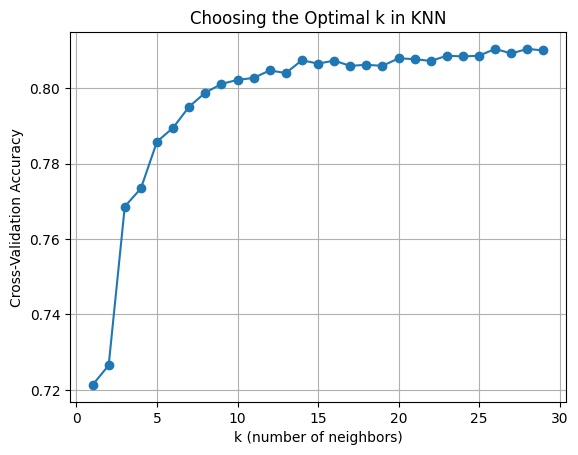

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ks = range(1, 30)

scores = [
    cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train_scaled, y_train, cv=5).mean()
    for k in ks
]

plt.plot(ks, scores, marker='o')
plt.xlabel('k (number of neighbors)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Choosing the Optimal k in KNN')
plt.grid(True)
plt.show()

# elbow at k = 14

Computing accuracy of KNN on training set with cross-validation

In [15]:
acc_knn = cross_val_score(KNeighborsClassifier(n_neighbors = 14), X_train_scaled, y_train, cv = 5).mean()
print(acc_knn)
knn_clf = KNeighborsClassifier(n_neighbors = 14)

0.8074


**XGboost**

In [16]:
pip install xgboost -q

Note: you may need to restart the kernel to use updated packages.


In [17]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
acc_xgb = cross_val_score(xgb_clf, X_train_scaled, y_train, cv =5).mean()
print(acc_xgb)

0.8235999999999999


**Random forest**

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
acc_rf = cross_val_score(rf_clf, X_train_scaled, y_train, cv = 5).mean()

print(acc_rf)

0.8269


**Ensamble (Stacking)**  
Our choice for this submission is to use voting ensamble technique using as models all the ones computed previously:
- logistic regression
- knn
- xgboost
- random forest\
The idea is to use a logistic regression with inputs given by the labels predicted by the base models.

In [19]:
from sklearn.ensemble import StackingClassifier

In [20]:
models = [
    ("lr", best_log_reg),
    ("xgb", xgb_clf),
    ("knn", knn_clf),
    ('rf', rf_clf)
]

meta_learner = LogisticRegression(random_state = 42, max_iter = 1000)

stacking_xgb_rf = StackingClassifier(
    estimators=models,
    final_estimator=meta_learner,
    cv=5  # cross-validation for base model predictions
)

In [21]:
param_grid = {
    'final_estimator__C': [0.1, 1, 1.5, 2],
    'final_estimator__penalty': ['l1', 'l2'],
    'final_estimator__solver': ['liblinear', 'lbfgs']
}

grid_xgb_rf = GridSearchCV(stacking_xgb_rf, param_grid, scoring = ["roc_auc", "accuracy"], refit = "roc_auc",n_jobs = 4 , cv=5)
grid_xgb_rf.fit(X_train_scaled, y_train)
predictions_stack_xgb_rf = grid_xgb_rf.best_estimator_.predict(X_test_scaled)


xgb_rf_results_df = pd.DataFrame(grid_xgb_rf.cv_results_)
best_idx = grid_xgb_rf.best_index_
acc_stacking_xgb_rf = xgb_rf_results_df.loc[best_idx, 'mean_test_accuracy']

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py", line 660, in fit
    return super().fit(X, y_encoded, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py", line 276, in fit
    _fit_single_es

In [22]:
print(f"accuracy con xgboost e rf {acc_stacking_xgb_rf}")

accuracy con xgboost e rf 0.8324


# **Creating the Submission File**  
The competition requires a `.csv` file with two columns: `battle_id` and `player_won`. Let's use our trained model to make predictions on the test set and format them correctly.

In [23]:
# Make predictions on the test data
print("Generating predictions on the test set...")
#test_predictions = model.predict(X_test)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    #'player_won': test_predictions
    'player_won': predictions_stack_xgb_rf
})

# Save the DataFrame to a .csv file
submission_df.to_csv('submission.csv', index=False)

print("\n'submission.csv' file created successfully!")
display(submission_df.head())

Generating predictions on the test set...

'submission.csv' file created successfully!


,battle_id,player_won
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
